# Ensemble Testing
This Notebook is used to test the performance of a GNN ensemble.
The training of ```n_reps``` models is done in ```ensemble_train.py``` and can be configured using ```ensemble_config.yaml```.

In [36]:
import sys
import subprocess
from multiprocessing import Process

from ensemble_train import crps, create_model
import numpy as np
import os
import sys
import torch
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import yaml

sys.path.append('../utils')
import helpers

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.size': 16})


from scipy.stats import norm
%matplotlib inline

In [51]:
ensemble_config = "experiments/small/best_GraphSage/config.yaml"

with open(ensemble_config, 'r') as config_file:
    config = yaml.safe_load(config_file)

save_path = os.path.dirname(ensemble_config)

## Train an Ensemble based on the config

In [7]:
def split_list(input_list, n):
    return [input_list[i:i + n] for i in range(0, len(input_list), n)]

def run_script(params):
    """
    Train a single model by launching a single subprocess facilitating the training
    :param params: tuple containing the id of the run, the device number and the name of the config file for the run
    """
    if "small" in params[2]:
        small = True
    else:
        small = False

    id_val, device_val, config_val = params
    cmd = [sys.executable, "ensemble_train.py", "--id", str(id_val), "--device", str(device_val), "--config", config_val, "--small" if small else "--no-small"]
    subprocess.run(cmd)

def train_ensemble(config_path, n):
    """
    Trains an ensemble of models
    :param config_path: path to the config file of the models
    :param n: number of models to train in parallel
    """
    params = [(i, i%2, config_path) for i in range(10)]
    params_list_list = split_list(params, n)

    for params_list in params_list_list:
        print(f"Start training of models")
        processes = []
        for params in params_list:
            print(params[0])
            process = Process(target=run_script, args=(params,))
            processes.append(process)
            process.start()

        for process in processes:
            process.join()

In [8]:
%%time
train_ensemble(ensemble_config, 10)

Start training of models
0
1
2
3
4
5
6
7
8
9
Model 0 start
Stopped 0
Model 8 start
Stopped 8
Model 6 start
Stopped 6
Model 4 start
Stopped 4
Model 2 start
Stopped 2
Model 3 start
Stopped 3
Model 1 start
Stopped 1
Model 5 start
Stopped 5
Model 7 start
Stopped 7
Model 9 start
Stopped 9
CPU times: user 92.5 ms, sys: 181 ms, total: 274 ms
Wall time: 33min 18s


# Evaluation

In [52]:
# Get Data from feather
print("Loading Data ...")
data = helpers.load_data(indexed=False)

if not os.path.exists("dist_matrix.npy"):
    print("Creating distance matrix ...")
    stations = helpers.load_stations(data)  # This needs to be done here because we need all stations
    dist_matrix = helpers.compute_dist_matrix(stations)
    np.save('dist_matrix.npy', dist_matrix)

# Clean Data
print("Cleaning Data ...")
data = helpers.clean_data(data, max_missing=121, max_alt=1000.0)

# Normalize Data
print("Normalizing Data ...")
normalized_data = helpers.normalize_data(data, last_obs=-366, method="max") #last_obs is -365 since the last year is used for testing

# Get List of stations with all stations -> will break further code if cut already
print("Extracting Stations ...")
stations = helpers.load_stations(data)


dist_matrix = np.load('dist_matrix.npy')
corr_matrix = np.load('corr_matrix.npy')
position_matrix = np.array(stations[['station', 'lon', 'lat']])


torch_data_test = []
for date in tqdm(data['date'].unique()[-366:], desc="Creating PyG Data"):
    torch_data_test.append(helpers.create_data(df=normalized_data,
                                               date=date,
                                               dist_matrix=dist_matrix if not config['data']['use_corr'] else corr_matrix,
                                               position_matrix=position_matrix,
                                               method=config['data']['method'],
                                               max_dist=config['data']['max_dist'],
                                               k=config['data']['nearest_k'],
                                               nearest_k_mode=config['data']['nearest_k_mode']))

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Move all the data directly to the GPU (should fit into memory)
# torch_data_train only contains training datat 2007-2015
torch_data_test = [tensor.to(device) for tensor in torch_data_test]

# Definition of train_loader and valid_loader
test_loader = DataLoader(torch_data_test, batch_size=8, shuffle=False)

Loading Data ...
Cleaning Data ...
Normalizing Data ...
Extracting Stations ...


Creating PyG Data: 100%|██████████| 366/366 [00:03<00:00, 109.01it/s]


In [53]:
def get_models_from_checkpoints():
    emb_num_features = torch_data_test[0].num_features + config['model']['embed_dim'] - 1

    model_list = []
    for snapshot in os.listdir(f"{os.path.dirname(ensemble_config)}/checkpoints"):
        path_to_snapshot = f"{os.path.dirname(ensemble_config)}/checkpoints/{snapshot}"
        model = create_model(config, emb_num_features)
        try:
            checkpoint = torch.load(path_to_snapshot)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(device)
            model_list.append(model)
        except:
            print(f"could not load {path_to_snapshot}, model architectures do not match")
    return model_list

def evaluate_ensemble(model_list:list):
    mu_list_model = []
    sigma_list_model = []

    for model in model_list:
        mu_list_batch = []
        sigma_list_batch = []
        y_list = []

        for batch in test_loader:
            batch.to(device)
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            mu, sigma = torch.split(out, 1, dim=-1)
            y = batch.y
            y = y.cpu().numpy()
            y_list.append(y)

            mu = mu.detach().cpu().numpy().flatten()
            mu_list_batch.append(mu)
            sigma = sigma.detach().cpu().numpy().flatten()
            sigma_list_batch.append(sigma)


        mu = np.concatenate(mu_list_batch)
        mu_list_model.append(mu)
        sigma = np.concatenate(sigma_list_batch)
        sigma_list_model.append(sigma)
        y = np.concatenate(y_list)
    mu = np.array(mu_list_model).T.mean(axis=1).reshape(-1,1)
    sigma = np.array(sigma_list_model).T.mean(axis=1).reshape(-1,1)

    mu = torch.tensor(mu).to(device)
    sigma = torch.tensor(sigma).to(device)
    preds = torch.cat([mu, sigma], dim=1)
    y = torch.tensor(y).to(device)
    err = crps(mu_sigma=preds, y=y)

    y = y.detach().cpu().numpy()
    mu = mu.detach().cpu().numpy()
    sigma = sigma.detach().cpu().numpy()
    return err, mu, sigma, y

In [54]:
ensemble = get_models_from_checkpoints()
err, mu, sigma, y = evaluate_ensemble(ensemble)
print(err)

Model crps 0.784573495388031
Model crps 0.808352530002594
Model crps 0.8034158945083618
Model crps 0.8158273100852966
Model crps 0.7844380140304565
Model crps 0.7766989469528198
Model crps 0.7826502919197083
Model crps 0.7885094285011292
Model crps 0.7856797575950623
Model crps 0.7933775782585144
Ensemble CRPS: 0.768977701663971


# Plot
## Observed vs. Actual value

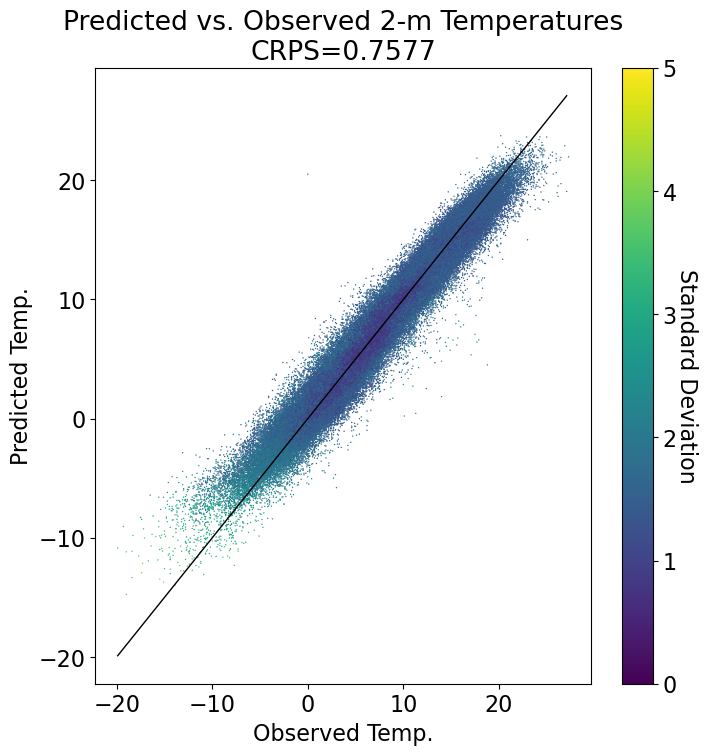

In [12]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,8))
plt.plot(np.arange(np.min(y),np.max(y),1), np.arange(np.min(y),np.max(y),1), linewidth=1, color="black")  # line
plt.scatter(y, mu, c=sigma, s=1, linewidth=0, cmap="viridis", vmin=0, vmax=5)

cbar = plt.colorbar()
cbar.set_label('Standard Deviation', rotation=270, labelpad=15)
plt.xlabel('Observed Temp.')
plt.ylabel('Predicted Temp.')
plt.title(f"Predicted vs. Observed 2-m Temperatures\nCRPS={err:.4f}")
plt.savefig(f"{save_path}/predsObs.eps", format='eps', dpi=300, bbox_inches='tight')

## PIT Histogram

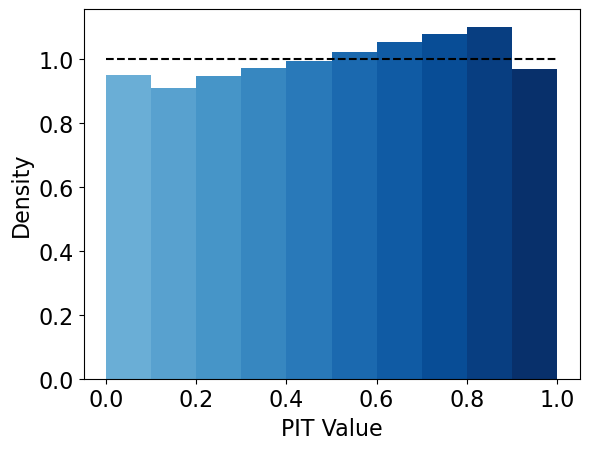

In [13]:
probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
n, bins, patches = plt.hist(probs, bins=10, density=True)

# colors
cm = mpl.colormaps['Blues']
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= (max(col))

def scale_interval(value, min_in, max_in, min_out, max_out):
    # Scale value from [min_in, max_in] to [min_out, max_out]
    scaled_value = min_out + (value - min_in) * (max_out - min_out) / (max_in - min_in)
    return scaled_value

col = scale_interval(col, 0, 1, 0.5,1)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.hlines(xmin=0,xmax=1, y=1, colors="black", linestyles="--")
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.savefig(f"{save_path}/PIT.eps", format='eps', dpi=300, bbox_inches='tight')

## Kolmogorow-Smirnow-Test
The Kolmogorov-Smirnov test is a non-parametric statistical test used to assess whether a sample comes from a specific distribution. It is based on the comparison of the empirical distribution function of the sample with the cumulative distribution function of the hypothesized distribution.
$H_0: F_X=F_0\\
H_1: F_X \neq F_0$

In [10]:
from scipy.stats import kstest, uniform

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = kstest(probs, uniform.cdf)

print(p_value)

0.0
